# Eye tracking: Decoding

## Overview
We trained a time-resolved linear decoder very comparable to the EEG decoder also on the eye tracking data. here we simply used the horizontal and vertical (here expressed as spherical angles) gaze coordinates as input features.  
We applied this procedure to decode mostly the same targets as from the EEG, to see how well this works on the eye tracking data.  

Please note: the actual decoding work was(/is better) done outside of this notebook (i.e., from the command line or better a HPC system). While it should theoretically also work from here, it is not tuned for performance (esp. in a notebook) and might take very long (hours to days) whereas when parallelized along the participant dimension. It only took ~30 minutes to run it on our HPC system. You can find the according slurm script `DECOD_ET.sh` in the `code\HPC` folder. 
  
The general idea is to have the decoding results saved into the `data` folder and then we read them out in this script to visualize and analyze them. 

Here is how to run the decoding from terminal (make sure to be in the root directory of the project and to have the proper conda environemnt activated)
```bash
python3.10 vr2f/code/vr2f/eyetracking/et_decoding.py 0 all
```
will run the decoding for the first (out of 17) participants and for all of the classifications which we investigated.  
If you want to run only the (multiclass) decoding of the emotional expressions you can run: 
```bash
python3.10 vr2f/code/vr2f/eyetracking/et_decoding.py 0 emotion
```
For the decoding of 2D vs 3D viewing conditions:
```bash
python3.10 vr2f/code/vr2f/eyetracking/et_decoding.py 0 viewcond
```
The index (first argument) refers to the (sorted) files in the preprocessed data folder (`data\eye_tracking\01_preproc`), so of you want to run it only for a specific participant, please go count the files. ;)

Once we have done this (or downloaded the data), we should hae all necessary folders and files in `data\eye_tracking\03_decoding` and load the for the visualizations here. 

In [2]:
%load_ext autoreload
%autoreload 2

import os
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
import mne
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.lines import Line2D
from scipy import stats
from vr2f import helpers
from vr2f.staticinfo import COLORS, CONFIG, PATHS


In [3]:
def load_decod_res_per_viewcond(
    sub_list_str,
    conditions,
    vc_list=[],
    scoring="roc_auc_ovr",
):
    data_dict = dict()

    if len(vc_list) == 0:
        vc_list = [""]

    paths = PATHS()

    contrast_str = "_vs_".join(conditions)

    for vc in vc_list:
        data_dict[vc] = dict(scores=[], times=[])
        for subID in sub_list_str:
            fpath = Path(
                paths.DATA_ET_DECOD,
                vc,
                contrast_str,
                scoring,
                "scores",
            )
            fname = Path(fpath, f"{subID}-scores_per_sub.npy")
            scores_ = np.load(fname)
            data_dict[vc]["scores"].append(np.mean(scores_, axis=0))

            if len(data_dict[vc]["times"]) == 0:
                data_dict[vc]["times"] = np.load(str(fname)[:-4] + "__times" + ".npy")

        data_dict[vc]["scores"] = np.array(data_dict[vc]["scores"])

    return data_dict


def load_decod_res_per_contrast(
    sub_list_str,
    contrasts,
    scorings,
    vc_list=[],
):
    data_dict = dict()

    if len(vc_list) == 0:
        vc_list = [""] * len(contrasts)
    elif len(vc_list) == 1:
        vc_list = vc_list * len(contrasts)
    elif len(vc_list) != len(contrasts):
        raise ValueError("vc_list must be same length as contrasts")

    if len(scorings) == 1:
        scorings = scorings * len(contrasts)
    elif len(scorings) != len(contrasts):
        raise ValueError("scorings must be same length as contrasts")

    paths = PATHS()

    contrast_str_list = ["_vs_".join(c) for c in contrasts]

    times = []
    for idx, c in enumerate(contrast_str_list):
        data_dict[c] = dict(scores=[], times=[])
        for subID in sub_list_str:
            fpath = Path(
                paths.DATA_ET_DECOD,
                vc_list[idx],
                c,
                scorings[idx],
                "scores",
            )
            fname = Path(fpath, f"{subID}-scores_per_sub.npy")
            scores_ = np.load(fname)
            data_dict[c]["scores"].append(np.mean(scores_, axis=0))

            if len(times) == 0:
                times = np.load(str(fname)[:-4] + "__times" + ".npy")
            data_dict[c]["times"] = times

        data_dict[c]["scores"] = np.array(data_dict[c]["scores"])

    return data_dict


def plot_score_per_factor(
    factor,
    data,
    scoring="accuracy",
    sign_clusters=[],
    p_lvl=0.05,
    chancelvl=0.5,
    ylims=None,
    xlims=None,
    ax=None,
    n_boot=1000,
    palette=None,
):
    if palette is None:
        colors = COLORS()
        palette = colors.COLDICT

    sns.lineplot(
        x="time",
        y="score",
        hue=factor,
        data=data,
        n_boot=n_boot,
        palette=palette,
        ax=ax,
        linewidth=1.5,
        legend=False,
        errorbar="se",
    )
    ytick_range = ax.get_ylim()
    if ylims is None:
        ylims = ytick_range
    ax.set(xlim=xlims, ylim=ylims)
    scoring_str = "ROC AUC" if scoring == "roc_auc" else scoring
    ax.set_ylabel(scoring_str)
    ax.set_xlabel("Time (s)")

    ax.text(x=1.0, y=chancelvl + 0.001, s="chance", ha="right")

    palette["diff"] = "red" if "red" not in palette.values() else "pink"

    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)

    ax.vlines(
        (0),
        ymin=ylims[0],
        ymax=ylims[1],
        linestyles="dashed",
        linewidth=0.5,
        color="black",
    )
    ax.hlines(
        chancelvl,
        xmin=xlims[0],
        xmax=xlims[1],
        linewidth=0.5,
        color="black",
    )
    p_lvl_str = "$p$ < ." + str(p_lvl).split(".")[-1]
    if isinstance(sign_clusters, dict):
        for i, key in enumerate(sign_clusters):
            col = palette[key.lower()]
            for sc in sign_clusters[key.lower()]:
                xmin = sc[0]
                xmax = sc[-1]
                y_ = ylims[0] + (0.04 - ((i + 1) * 0.025) * np.ptp(ylims))
                ax.hlines(
                    y_,
                    xmin=xmin,
                    xmax=xmax,
                    color=col,
                    label=p_lvl_str,
                )
            if i == 0 & len(sign_clusters[key.lower()]) > 0:
                ax.text(x=1.0, y=y_ + 0.001, s=p_lvl_str, ha="right")

    else:
        for sc in sign_clusters:
            xmin = sc[0]
            xmax = sc[-1]
            y_ = ytick_range[0] + 0.05 * np.ptp(ytick_range)
            ax.hlines(
                y_,
                xmin=xmin,
                xmax=xmax,
                color="purple",
                label=p_lvl_str,
            )
        if len(sign_clusters) > 0:
            ax.text(x=1.0, y=y_ + 0.001, s=p_lvl_str, ha="right")

    handles, labels = ax.get_legend_handles_labels()
    n_sgn_clu = None if len(sign_clusters) <= 1 else -(len(sign_clusters))
    # ax.legend(handles=handles[1:n_sgn_clu+1], labels=labels[1:n_sgn_clu+1])


def run_cbp_test(data, tail=0):
    # number of permutations to run
    n_permutations = 10000
    # set initial threshold
    p_initial = 0.05
    # set family-wise p-value
    p_thresh = 0.05
    connectivity = None
    tail = tail  # 1 or -1 for one-sided test, 0 for two-sided

    config = CONFIG()

    # set cluster threshold
    n_samples = len(data)
    threshold = -stats.t.ppf(p_initial / (1 + (tail == 0)), n_samples - 1)
    if np.sign(tail) < 0:
        threshold = -threshold

    cluster_stats = mne.stats.permutation_cluster_1samp_test(
        data,
        threshold=threshold,
        n_jobs=config.N_JOBS,
        verbose=False,
        tail=tail,
        step_down_p=0.0005,
        adjacency=connectivity,
        n_permutations=n_permutations,
        seed=42,
        out_type="mask",
    )

    T_obs, clusters, cluster_p_values, _ = cluster_stats
    return T_obs, clusters, cluster_p_values


def prep_and_plot_from_data(
    data_dict, subsets, ax, chancelvl=0.25, ylims=(0.2, 0.32), scoring="roc_auc", palette=None
):
    # Prepare data for plotting with seaborn:
    results_df_list = list()
    for vc in subsets:
        times = data_dict[vc]["times"]
        acc = np.asarray(data_dict[vc]["scores"])
        acc_df = pd.DataFrame(acc)
        acc_df.columns = times
        df = acc_df.melt(var_name="time", value_name="score")  # put into long format
        df["vc"] = vc
        results_df_list.append(df)
    data_plot = pd.concat(results_df_list)

    sign_cluster_times = {}
    # run CBP to find differences from chance:
    for vc in subsets:
        data = np.asarray(data_dict[vc]["scores"]) - chancelvl
        t_values, clusters, p_values = run_cbp_test(data, tail=1)
        idx_sign_clusters = np.argwhere(p_values < p_val_cbp)
        sign_cluster_times[vc] = [times[clusters[idx[0]]][[0, -1]] for idx in idx_sign_clusters]

    if len(subsets) == 2:
        # run CBP to find difference between conditions:
        data = np.asarray(data_dict[subsets[0]]["scores"]) - np.asarray(data_dict[subsets[1]]["scores"])
        t_values, clusters, p_values = run_cbp_test(data, tail=0)
        idx_sign_clusters = np.argwhere(p_values < p_val_cbp)
        sign_cluster_times["diff"] = [times[clusters[idx[0]]][[0, -1]] for idx in idx_sign_clusters]
        if len(sign_cluster_times["diff"]) > 0:
            helpers.print_msg("Found significant difference between conditions! Do you see that?")
    else:
        sign_cluster_times["diff"] = []
        print(
            "Not checking for difference between conditions (only implemented \
        for 2 groups)."
        )

    # Plot it:

    plot_score_per_factor(
        factor="vc",
        data=data_plot.reset_index(),
        scoring=scoring,
        sign_clusters={ecc: sign_cluster_times[ecc] for ecc in subsets + ["diff"]},
        p_lvl=p_val_cbp,
        chancelvl=chancelvl,
        ylims=ylims,
        xlims=(-0.3, 1.0),
        n_boot=10000,
        palette=palette,
        ax=ax,
    )

## Setup 

### Parameters
Set some parameters for plotting

In [4]:
# Setup:
matplotlib.rcParams["pdf.fonttype"] = 42
matplotlib.rcParams["ps.fonttype"] = 42
matplotlib.rcParams.update({"font.size": 16})
cm = 1 / 2.54  # inch to cm

# p-value for the CBP test
p_val_cbp = 0.05


## Load decoding results from disc

In [5]:
paths = PATHS()
path_in = Path(
    paths.DATA_ET_DECOD, "neutral_vs_happy_vs_angry_vs_surprised", "roc_auc_ovr", "scores"
)

sub_list_str = [s.split("-scores")[0] for s in os.listdir(path_in)]
sub_list_str = np.unique(sorted(sub_list_str))

data_dict_allemos = load_decod_res_per_viewcond(
    sub_list_str=sub_list_str,
    conditions=["neutral", "happy", "angry", "surprised"],
    vc_list=[""],  # we do not differentiate the viewing conditons here
    scoring="roc_auc_ovr",
)
data_dict_allemos["all"] = data_dict_allemos.pop("")


This now gives us a dictionnary from which we can draw the relevant data for visualization. We create a second, more detailled one:

In [6]:
cond_dict = {
    "viewcond": {1: "mono", 2: "stereo"},
    "emotion": {1: "neutral", 2: "happy", 3: "angry", 4: "surprised"},
    "avatar_id": {1: "Woman_01", 2: "Woman_04", 3: "Woman_08"},
}

contrasts = [
    ["neutral", "happy", "angry", "surprised"],
    ["angry", "neutral"],
    ["happy", "neutral"],
    ["surprised", "neutral"],
    ["angry", "happy"],
    ["angry", "surprised"],
    ["happy", "surprised"],
]

data_dict_allcontrasts = load_decod_res_per_contrast(
    sub_list_str=sub_list_str,
    contrasts=contrasts,
    scorings=["roc_auc_ovr"] * len(contrasts),
)

contrasts_str_list = ["_vs_".join([c.lower() for c in contr]) for contr in contrasts]
colors = COLORS()
colors_custom = [colors.COLDICT[c] for c in contrasts_str_list]
# ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3']
palette = {contr: colors_custom[i] for i, contr in enumerate(contrasts_str_list)}




## Plotting: multiclass decoding of emotional expressions

We plot the time-resolved decoding for the classification of the 4 different emotional expressions. Chance level is at 0.5 as our scorer for the classification performance is ROC AUC (which is 0.5 at chance), set up as a "one-vs-rest" problem for evaluating the results (for details see [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#one-vs-rest-multiclass-roc)).  
The horizontal line at the bottom visualizes the result from a CBP test (i.e., it indicates a "significant cluster" for which the decoding performance was significantly higher than chance level). 

Not checking for difference between conditions (only implemented         for 2 groups).


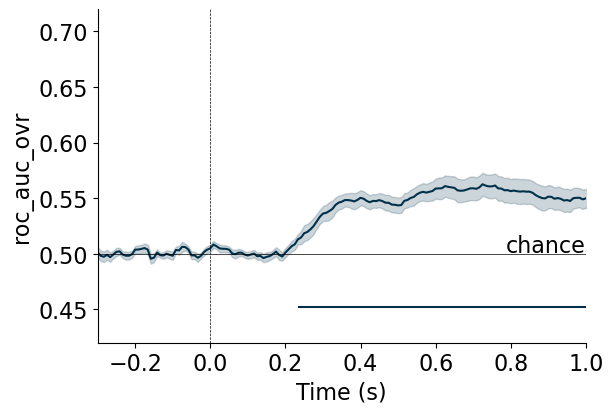

In [7]:
fig, ax = plt.subplots(1, figsize=(16 * cm, 11 * cm))
prep_and_plot_from_data(
    data_dict_allemos, subsets=["all"], ax=ax, chancelvl=0.5, ylims=(0.42, 0.72), scoring="roc_auc_ovr"
)

## Plotting: selected binary contrasts (emo. expressions) and multiclass decoding

Not checking for difference between conditions (only implemented         for 2 groups).


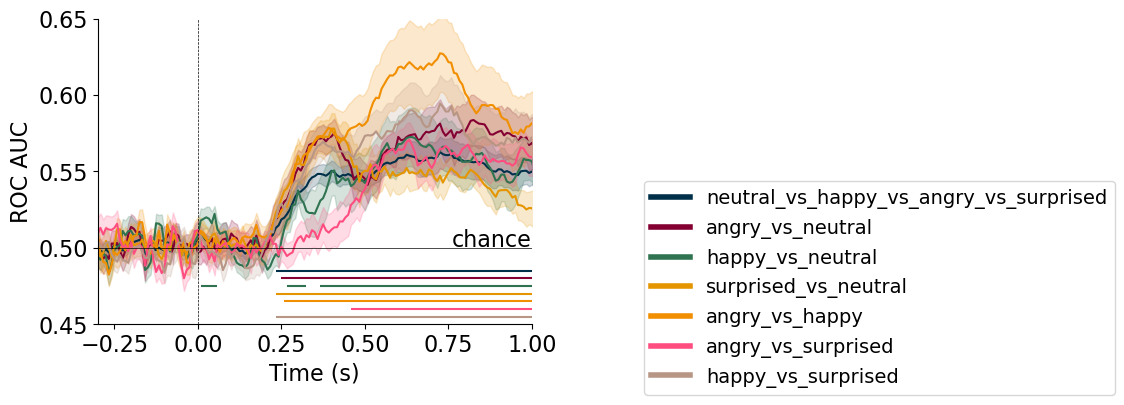

In [8]:
fig, ax = plt.subplots(1, figsize=(14.2328 * cm, 10.0786 * cm))
prep_and_plot_from_data(
    data_dict_allcontrasts,
    subsets=contrasts_str_list,
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.65),
    scoring="roc_auc",
    palette=palette,
)
# add custom legend using palette and place it outside of the plot:
legend_elements = [Line2D([0], [0], color=palette[contr], lw=4, label=contr) for contr in contrasts_str_list]
ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(1.8, 0.5), ncol=1, fontsize=14)


# save:
fig.savefig(
    Path(paths.FIGURES, "decod_et_allcontrasts.pdf"),
    dpi=300,
    # bbox_inches="tight",
)

/u/fklotzsche/conda-envs/vr2fem/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



#####################################################################################
Found significant difference between conditions! Do you see that?
#####################################################################################



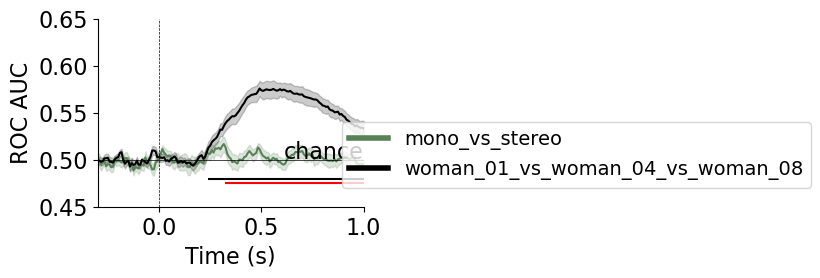

In [9]:
contrasts = [
    ["mono", "stereo"],
    [ava_id.lower() for ava_id in cond_dict["avatar_id"].values()],
]
data_dict_taskirr_contrasts = load_decod_res_per_contrast(
    sub_list_str=sub_list_str,
    contrasts=contrasts,
    scorings=[
        "roc_auc_ovr",
    ],
)

contrasts_str_list = ["_vs_".join([c.lower() for c in contr]) for contr in contrasts]
colors = COLORS()
colors_custom = [colors.COLDICT["viewcond"], "black"]
palette = {contr: colors_custom[i] for i, contr in enumerate(contrasts_str_list)}


fig, ax = plt.subplots(1, figsize=(8.7152 * cm, 6.1993 * cm))
prep_and_plot_from_data(
    data_dict_taskirr_contrasts,
    subsets=contrasts_str_list,
    ax=ax,
    chancelvl=0.5,
    ylims=(0.45, 0.65),
    scoring="roc_auc",
    palette=palette,
)
# add custom legend using palette and place it outside of the plot:
legend_elements = [Line2D([0], [0], color=palette[contr], lw=4, label=contr) for contr in contrasts_str_list]
ax.legend(handles=legend_elements, loc="upper center", bbox_to_anchor=(1.8, 0.5), ncol=1, fontsize=14)


# save:
fig.savefig(
    Path(paths.FIGURES, "decod_et_taskirr_contrasts.pdf"),
    dpi=300,
    # bbox_inches="tight",
)